In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pickle as pkl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

import = send



In [3]:
dir_train =  '/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train'
dir_val = '/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation'
bearing = ['Bearing1_1','Bearing1_2','Bearing2_1','Bearing2_2','Bearing3_1','Bearing3_2']

**Helper Function**

In [4]:
def load_file(path):
  with open(path, 'rb') as f:
    return(pkl.load(f))

class PHMDataset(Dataset):

  def __init__(self,pfiles=[]):
      self.data = {'x':[], 'y':[]}
      for pfile in pfiles:
          _data = load_file(pfile)
          self.data['x'].append(_data['x'])
          self.data['y'].append(_data['y'])

      #joining list of horiz accel feature values & vert accel feature values of all 6
      #different bearing training pickle files as one.
      #list of horizontal accel feature values & vert accel feature values of all 6 training files
      self.data['x'] = np.concatenate(self.data['x']) #(....,2,128,128)

      #joining list of failure probability values of all 6 pfiles
      self.data['y'] = np.concatenate(self.data['y'])[:,np.newaxis] #(...,1)

  def __len__(self):
      return self.data['x'].shape[0]

  #i is use to access ith data in tensor
  def __getitem__(self, i):
      sample = {'x' : torch.from_numpy(self.data['x'][i]), 'y': torch.from_numpy(self.data['y'][i])}
      return sample    

In [5]:
path = "/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/model"
train_dataset= load_file(path + "/train.pkz")
val_dataset = load_file(path + "/val.pkz")


In [6]:
print(len(train_dataset), len(val_dataset))
print(train_dataset.data['x'].shape)

6783 751
(6783, 2, 128, 128)


In [7]:
#batch_size => no. of samples in each batch
#train  dataset is divided in batches and each batch contains 64 samples/datafiles
#val  dataset is divided in batches and each batch contains 64 samples/datafiles
train_batch_size = 64 
val_batch_size = 64

In [8]:
'''
torch DataLoader
sample dataloader(train_dataloader) that loads batch of 64 samples(data files) at 
a time from train_dataset (without any multiprocessing 
(= simultaneously process two or more batches of data)

sample dataloader(val_dataloader) that loads batch of 64 samples(data files)
 at a time from val_dataset (without any multiprocessing 
 (= simultaneously process two or more batches of data)
'''
#num_workers => no. of processes needed for loading the data, here, 
#num_workers=1, therefore 1 time processing will be carried out for data loading


train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size = val_batch_size, shuffle=True, num_workers=1)

N: batch size

C: no. of channels or no. fo filters

H: height of an image in pixels

W: width of an image in pixels

**NOTE**

pytorch expects/takes input to CNN as shape - [NxCxHxW] as opposed to [NxH*WxC] in keras or tensorflow. We alreadly have input image feature shape [CxHxW] format stored in pickle files


#**CNN MODEL**

REFERENCE LINK:

1. CONV2D: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

2. SEQUENTIAL: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

3. BATCHNORM1D: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

4. BATCHNORM2D: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d

5. RELU: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU




conv_bn_relu:  conv -> convolution | bn -> batch normalization | relu -> rectified linear units layer activation function

in_channels (int datatype only) - No. of channels or number of filters in the input image

out_channels (int datatype only) - No. of channels or number of filters produced by the convolution



In [9]:
def conv_bn_relu(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', batch_norm=True):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode)
    nn.init.xavier_uniform_(conv.weight)
    relu = nn.ReLU()
    if batch_norm:
        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            relu
        )
    else:
        return nn.Sequential(
            conv,
            relu
        )

#CNN for Fault Probability Prediction

REFERECNES:

1) torch.nn.Module

In [10]:
class CNN_FP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_bn_relu(2, 16, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = conv_bn_relu(16, 32, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = conv_bn_relu(32, 64, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = conv_bn_relu(64, 128, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # input shape = [Nx2x128x128]
        x = self.conv1(x) # [Nx16x128x128]
        x = self.pool1(x) # [Nx16x64x64]
        x = self.conv2(x) # [Nx32x64x64]
        x = self.pool2(x) # [Nx32x32x32]
        x = self.conv3(x) # [Nx64x32x32]
        x = self.pool3(x) # [Nx64x16x16]
        x = self.conv4(x) # [Nx128x16x16]
        x = self.pool4(x) # [Nx128x8x8]
        x = self.flatten(x) # [Nx8192] {128*8*8=8192} (N => batch size, 128 => no. of channels, 8*8 => height of image*width of image)
        x = self.fc1(x) # [Nx256]
        # x = self.dropout1(x) # apply dropout
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc2(x) # [Nx128]
        # x = self.dropout2(x) # apply dropout
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc3(x) # final fully connected layer (or) final linear layer [Nx1] -> output is probability of fault
        return x

#**Switching from CPU to GPU**

Why switch from CPU to GPU? - training artificial neural networks or deep neural networks(like CNN) with CPU takes more time whereas training with GPU takes very less time compared to CPU. (training time on GPU = 100 * training time on CPU). Therefore GPUs should be used for model training to reduce the training time


In [11]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# Declaring a variable "device" which will hold the device(i.e. either GPU or CPU) we are 
#training the model on
#Utilizing GPU for computation with CUDA tensor

print(device) #this prints the device type
device

cuda:0


device(type='cuda', index=0)

**(2) (2) Connecting(=linking) our model to the device(GPU) to train the model on GPU. (Model training on GPU takes very less time compared to model training on CPU)**

References:

(1) How to train models on the GPU - https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99

In [13]:
model = CNN_FP().to(device) 

#**TRAINING THE MODEL**

**(1) **

**LOSS FUNCTION**
*  Loss function is a method of evaluating (= calculating) “how well our algorithm(prediction model or machine learning) models(performs on) our dataset”

* If our predictions are totally off, our loss function will output a higher number. If our predictions are pretty good, our loss function will output a lower number.

* Since we tune(=adjust) our algorithm to try and improve our model, our loss function will tell us whether our model is improving or not, loss function will tell us whether our model predicting correctly or not.

* ‘Loss’ helps us to understand how much the predicted value differ from actual value

https://medium.com/@zeeshanmulla/cost-activation-loss-function-neural-network-deep-learning-what-are-these-91167825a4de

**torch.nnMSELoss** ( = MSE Loss (Mean Squared Error Loss)
 (1) https://towardsdatascience.com/understanding-different-loss-functions-for-neural-networks-dd1ed0274718 , (2) https://deeplizard.com/learn/video/Skc8nqJirJg , (3) https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss

(RUL Prediction is a Regression problem. Regression problem => Predicting a value(output) for an input based on previous(=past) data. we are predicting the RUL of Mechanical Bearing using that Bearing's previous performance data (horiz accel and vert accel). Therefore RUL Prediction is considered as a regression problem)


(There are various types of Loss functions. Since RUL Prediction is a regression problem, MSE Loss(Mean Sqaured Error Loss) is used. Generally MSE Loss is used for regression tasks or regresion problems.)


**nnMSELoss**

* MSELoss, loss is calculated by taking the mean of squared difference b/w actual(target) values and predicted values

* For a single sample, with MSE, we first calculate the difference (the error) b/w the provided output prediction(i.e. actual value or target value) and the label(i.e. predicted value(our predicted value).

* We then square this error
( MSE(input) = (output - label)*(output - label) or MSE = (actual value - predicted value)*(actual value - predicted value) )

*   If we passed multiple samples to the model at once (a batch of samples), then we would take the mean of the squared errors over all of these samples


**nnMSELoss(reduction = 'sum')**


*  nn.MSELoss creates a criterion(= norm, model, measure) that measures the mean squared error between each element in the input x and target y (output y)
*  mean squared error = mean of squared differences between actual(target) values and predicted values

* MSELoss = [(actual output - predicted output) * (actual output - predicted output)] 

*  reduction specifies which reduction to apply to the output
   reduction = 'none => no reduction will be applied
   reduction = 'mean' => the output will be summed and the sum of the output will be divided by the number of elements in the output
   reduction = 'sum' => the output will be summed and the division by the number of elements in the outptu is avoided



In [14]:
# critetion => Here, criterion is the MSEcriterion
criterion = nn.MSELoss(reduction='sum')

**(2) Optimizer**

Optimization : maximization, enhancement, improvement, maximizing the model's peformance

*   To train a neural network model (such as CNN), we must define a loss function in order to measure the difference between actual value and prediction value(our prediction value).

*   Loss function is a method of evaluating (= calculating) “how well our algorithm(prediction model or machine learning) models(performs on) our dataset”. 
*  If our predictions are totally off(= wrong, mistaken), our loss function will output a higher number. 

* If our predictions are pretty good, our loss function will output a lower number. our loss function will tell us whether our model is improving or not, loss function will tell us whether our model predicting correctly or not.
* 'Loss' helps us to understand how much the predicted value differ from actual value
* We need to use this loss to train our network(model) such that it performs better. 
* Essentially what we need to do is to take the loss and try to minimize(=reduce) it, because a lower loss means our model is going to perform better
* Optimizers also called as Optimization algorithms are responsible for reducing the losses and to provide the most accurate results possible. Here we are using Adam optimizer(Adaptive Moment Estimation optimizer)

References:

References:

(a) Optimizer (= torch.optim) - https://pytorch.org/docs/stable/optim.html

(b)(1) https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html , (2) https://towardsdatascience.com/optimization-algorithms-in-deep-learning-191bfc2737a4


**torch.optim**

* It is a packlage implementing various optimization algorithms.
*  To use torch.optim you have to **construct an optimizer object**, that will hold the current state and will update the parameters based on the computed gradients.

gradient = gradient simply measures the change in all weights with respect to change in error(i.e. change in loss), basically gradient tells us that if loss changes how will the weights changes in neural networks). 

(gradient = difference in loss / difference in weights)

* **To construct an Optimizer** you have to give it an iterable containing the parameters (all should be Variables) to optimize(=improve, make perfect, develop, advance, maximize). Then, you can specify optimizer-specific options such as the learning rate, weight decay, etc. (iterable = iterable is an object, which one can iterate(=repeat, loop) over.

**NOTE** 

If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for model. Parameters of a model after .cuda() will be 
different objects with those before the call. In general, we should make sure that optimized parameters live in consistent(= unchanging) locations when 
optimizers are constructed and used.



**Adam Algorithm**

* It is an optmiztion algorithm useful for reducing the losses & to provide the most accurate results possible based on computed gradients.

* Basically, Adam Algorithm optimizes the model by reducing loss function so that the model predicted value and the actual value will be almost be same.

* A lower loss means our model is going to perfomr better


**lr (float, optional)**

* learning rate
* The learning rate is a hyperparameter(= hyperparameter is a variable which determines the network structure)  
* It controls how much to change the model in response to the estimated error each time the model weights are updated. 
* Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may 
result an unstable(= ambiguous, uncertain) training process. 
* Basically, learning rate is a parameter that determines how much an 
updating step influences(=effects, affects, impacts, controls) the current value of the weights. here, lr=0.001
  



In [ ]:
#optimizer is the optimizer object (i.e. torch.optim class object)

#optim.Adam : implements adam Algorithm

#model.parameter() : with this function we can loop over the parameters (which we want to optimize) of the model & then initialize each parameter with tensor functions

#lr(float, optional): learning rate
#the learning rate is a hyperparameter (= hyperparameter is a variable which determines the network structure) 
#that controls how much to change the model in response to the estimated error each time the model weights are updated
#learning rate is a parameter that determines how much an updating step influences the current value of the weights

#betas (Tuple[float, float], optional) – coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))

#eps (float, optional): term added to the denominator to improve numerical stability as the algorithm executes, having little effect on the final output (default: 1e-8)
# numerical stability - it refers to how a malformed input affects the execution of an algorithm.
# In numerically stable algorithm, errors in the input lessen as the algorithm executes, having little effect on the final output

#weigth_decay (float, optional) - weight decay (default: 0) 
#it changes the weights to exponentially decay to zero, if no other update is schedule

#amsgrad (boolean, optional) = whethe to use the AMSGrad variant of Adam algorithm or not. 
#AMSgrad is a variant of the optimizer Adam that uses the maxium of past squared gradients to update the parameter (default: False)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

**(3)**

**Learning Rate**
* In machine learning and statistics, the learning rate is a tuning(=adjusting) parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. learning rate also called as gain

*  The learning rate is a hyperparameter(= hyperparameter is a variable which determines the network structure) that controls how much to change the model in response to the estimated error each time the model weights are updated.

*   Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result an unstable(= ambiguous, uncertain) training process. 
*  learning rate can also be said as a parameter that determines how much an updating step influences(=effects, affects, impacts, controls) the current value of the weights.

*  we need learning rate to multiply the gradients. Basically, we multiply the gradients with learning rate. this learning rate is a small number usually ranging between 0.01 and 0.0001 but the actual value can vary, so any value we get for the gradient is going to become relatively small once we multiply with learning rate.

**Learning Rate Scheduler**


*   Learning rate scheduler improve the optimization process during the training.

*   Learning rate scheduler adjust(= modify, regulate, alter, change) our learning rate during the training loop based on the no. of epochs.
*   Learning Rate scheduler(or LR scheduler) adjust the learning rate for better results.
*  Adjusting the learning rate - means most of the time we want to decrease the learning rate, not increase the learning rate, but it always depends on our specific problem

*    Learning rate scheduler adjust the learning rate during training by reducing the learning rate

https://www.youtube.com/watch?v=81NJgoR5RfY

**Epoch**


*   An epoch means training the neural network with all the training data for one cycle

*   In an epoch, we use all of the data exactly once.
*   A forward pass and a backward pass together are counted as one pass.

*   An epoch is made up of one or more batches of the dataset and epoch is used to train the neural network.


*   One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. Since one epoch is too big to feed to the computer at once we divide it into several smaller batches


*   Passing the entire dataset through a neural network is not correct as neural network doesn't understand

* Therefore we need to pass the full(=entire, complete) dataset multiple times to the same neural network
* That means we divide the dataset into batches and pass each batch at a time to neural network.
* As the number of epochs increases, more number of times the weights are changed in the neural network and the curve goes from underfitting to optimal(= ideal, perfect) to overfitting curve

epoch - https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9


**Weight(s) in Neural Network**

* Weight is the parameter within a neural network that transforms(= changes) input data within the network's hidden layers. 
* A neural network is a series of nodes, or series of neurons. 
* Within each node there is a set of inputs, weights, and bias values
* As an input enters the node, it gets multiplied by a weight value and the resulting output is either observed, or passed to the next layer in the neural network.
* Often the weights of a neural network are contained within the hidden layers of the network.
*  Weight affects the amount of influence a change in the input will have upon the output.
* A low weight value will have no change on the input(therefore no change on the output or slight change on the output), and alternatively a larger weight value will more significantly change the output)


Reference:
torch.optim.lr_scheduler - https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


**MultiStepLR()** : one of the learning rate schedulers.MultiStepLR() Decays(= decreases) the learning rate of each 
                                          parameter group by gamma once the number of epoch reaches one of the milestones. Notice that such decay can happen 
                                          simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial 
                                          lr as lr







In [16]:
#torch.optim.lr_scheduler provides several methods to adjust(= modify, regulate, alter, change) the learning rate based on the number of epochs
# Learning rate scheduling should be applied after optimizer’s update
#MultiStepLR() is one of the learning rate schedulers.

#Optimizer (Optimizer) – Wrapped optimizer. (Optimizer also called as Optimization algorithm reduce the losses and provide the most accurate results possible.
#Here we are using Adam optimizer(Adaptive Moment Estimation optimizer)) 

#milestones (list) – List of epoch indices. Must be increasing.

#gamma (float) – Multiplicative factor(= multiplier, factor that multiplies) of learning rate decay(= decrease). Default: 0.1

#last_epoch (int) – The index(= position) of last epoch. Default: -1. When last_epoch=-1, sets initial lr as lr

#verbose (bool) – doubt

multistep_lr_sch = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1, last_epoch=-1, verbose=False)

**CALCULATING THE TRAIN LOSS**

**model.train()** => model.train() or model.train(mode=True) sets the mode to train. model.train() tells our model that we are training the model. So effectively 
                 layers like convolution, maxpool, ReLU, dropout, batchnorm etc. which behave different on the train and test procedures know what is going on 
                 and hence can behave accordingly. In case of model.train(): the model knows it has to learn the layers (Note: we think that train() function 
                 trains the model but it does not do that. train() just sets the mode and tells our model that we perform training on the model)


**optimizer.zero_grad()** 
https://pytorch.org/docs/master/generated/torch.optim.Optimizer.zero_grad.html
 

*   optimizer.zero.grad() => Sets(= assigns, allots) the gradients of all optimized torch.Tensor to zero.
*   In PyTorch, we need to set the gradients to zero before 
starting to do backpropragation(backward pass of inputs) because PyTorch accumulates(= adds, sums) the gradients on subsequent(= consecutive, successive, next) backward passes.
*   So, the default action is to accumulate (= sum, add) the gradients on every loss.backward() call.
*  Because of this, when we start our training loop, ideally we should zero out the gradients so that we do the parameter update correctly.
*  Else the gradient would point in some other direction than the 
intended(= planned) direction towards the minimum(in case of minimization objectives) or maximum (in case of maximization objectives))

  (gradient = gradient simply measures the change in all weights with respect to change in error(i.e. change in loss), basically gradient tells us that if loss 
changes how will the weights changes in neural networks).

  (gradient = difference in loss / difference in weights). 

  (the gradient is a numeric calculation 
allowing us to know how to adjust the parameters of a network in such a way that its output deviation is minimized) )

**loss.backward()** => applies back propagation(= back propagation is the process of updating(= changing) the weights of the neural network in order to reduce the 
                   error in prediction). basically loss.backward() is used to compute(= calculate, evaluate) gradients

**optimizer.step()** => 
https://pytorch.org/docs/stable/optim.html

(optimizer.step() => applies Gradient Descent(= gradient reduction). All optimizers or optimization algorithms implement a step() method, that updates
(= improves) the parameters. optimizer.step() function is used to update the parameters of neural network. optimizer.step() function can be called once the 
gradients are computed(= calculated, evaluated) using loss.backward() )

**loss.cpu().item()** 
*   loss.cpu() - copying loss to the cpu memory. actually loss present in gpu memory because we are training our model in the gpu memory.calculating the loss in gpu memory is not reliable as it consumes memory of gpu which leads to to cuda out of memory or gpu out of memory error. hence we are copying loss to the cpu memory and calculating loss
*   .item() act as a pytorch tensor so we can use it as a valu

In [17]:
def train_epoch(model, dataloader, criterion, optimizer):
    total_loss = 0
    num_of_samples = 0

    #sets the model to train
    model.train()

    #i, batch : iterator | dataloader : iterable
    #batch['x'] => horiz accel and vert accel feature values of train data
    #to (device) => here device is the GPU
    #A torch.dtype is an object that represents the data type of a torch.Tensor. dtype = torch.float represents 32-bit floating point number.                                
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float) #batch['x'] connects to GPU as floating point datatype
        y = batch['y'].to(device, dtype=torch.float) # fault probability values or failure probability values of val data) to the device

        #Sets(= assigns, allots) the gradients of all optimized torch.Tensor to zero
        optimizer.zero_grad()

        #predicting fault probability of train data using CNN
        y_prediction = model(x)

        #applies MSELoss to y_prediction and y
        loss = criterion(y_prediction, y)

        #applies back propagation
        loss.backward()

        #it is used to update the parameters of neural network
        optimizer.step()

        total_loss += loss.cpu().item() 
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples 

# train_losa = total_loss/num_of_samples

**CALCULATING THE VALIDATION LOSS**

In [18]:
def eval(model, dataloader, criterion):
    total_loss = 0
    num_of_samples = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        #python automatically closes the opened file(automatically releases the memory) without using close() function
        with torch.no_grad():
            y_prediction = model(x)             #predicting fault probability of val data using CNN
            loss = criterion(y_prediction, y)   #applies MSELoss to y_prediction and y

        total_loss += loss.cpu().item()         #copying loss to the cpu memory
        num_of_samples += x.shape[0]            #x.shape[0] => returns the shape of x in 0th dimension 
    return total_loss/num_of_samples

**Printing Train Loss & Val Loss**

**Epoch**

*   An epoch means training the neural network with all the training data for one cycle
*  In an epoch, we use all of the data exactly once.


*  A forward pass and a backward pass together are counted as one pass.

*  An epoch is made up of one or more batches of the dataset and epoch is used to train the neural network. 
*   One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. Since one epoch is too big to feed to the computer at 
once we divide it into several smaller batches


*   passing the entire dataset through a neural network is not 
correct as neural network doesn't understand


*  Therefore we need to pass the full(=entire, complete) dataset multiple times to the same neural network
*  that 
means we divide the dataset into batches and pass each batch at a time to neural network. As the number of epochs increases, more number of times the weights 
are changed in the neural network and the curve goes from underfitting to optimal(= ideal, perfect) to overfitting curve 


**multistep_lr_sch.step()** => means calling scheduler.step(), here scheduler(or learning rate scheduler) is multistep_lr_sch (If we don’t call scheduler.step(), 
                           the learning rate won’t be changed and stays at the initial value. Note: the scheduler will just manipulate the learning rate. It 
                           won’t update the model. Therefore you should call scheduler.step() in the epoch loop)





  


In [ ]:
#train loss and val loss will be calculated and displayed for maximium 30 epochs (1 to 30)
max_epochs = 30

# appending the list of train_loss and val_loss of every epoch from 1 to 30
loss_vals = []

for epoch in range(max_epochs):

    # the function which calculates train/val loss and returns the train/val loss of each epoch
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer)
    val_loss = eval(model, val_dataloader, criterion)

    multistep_lr_sch.step()
    loss_vals.append([train_loss, val_loss])
    print('{0}/{1}: train_loss = {2:.4f}, val_loss = {3:.4f}'.format(epoch+1, max_epochs, train_loss, val_loss) )

**Plotting train loss & val loss**

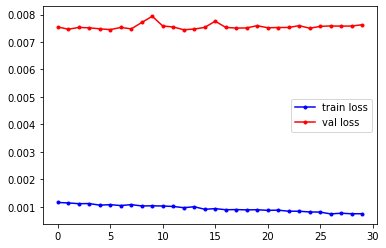

In [57]:
#Training1
plt.plot(range(max_epochs), [l[0] for l in loss_vals], 'b.-', label='train loss')
plt.plot(range(max_epochs), [l[1] for l in loss_vals], 'r.-', label='val loss')
plt.legend()
plt.show()
#underfitted model
#rejected

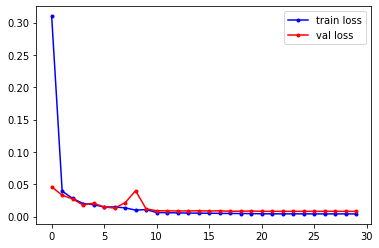

In [27]:
#Training2
plt.plot(range(max_epochs), [l[0] for l in loss_vals], 'b.-', label='train loss')
plt.plot(range(max_epochs), [l[1] for l in loss_vals], 'r.-', label='val loss')
plt.legend()
plt.show()
#accepted

Interpretation:
A good fit is the goal of the learning algorithm and exists between an overfit and underfit model.

A good fit is identified by a training and validation loss that decreases to a point of stability with a minimal gap between the two final loss values.

The loss of the model will almost always be lower on the training dataset than the validation dataset. This means that we should expect some gap between the train and validation loss learning curves. This gap is referred to as the “generalization gap.”

A plot of learning curves shows a good fit if:

The plot of training loss decreases to a point of stability.
The plot of validation loss decreases to a point of stability and has a small gap with the training loss.
Continued training of a good fit will likely lead to an overfit.

**SAVING THE MODEL**

model.state_dict() =>

 https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html , 
                      https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html
                      (In PyTorch, the learnable parameters (i.e. weights and biases) of a torch.nn.Module model are contained in the model’s parameters 
                      (accessed with model.parameters()). A state_dict is an essential entity(=object) if you are interested in saving or loading models from 
                      PyTorch. Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal 
                      of modularity to PyTorch models and optimizers. Note that only layers with learnable parameters (convolutional layers, linear layers, 
                      etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Saving the model’s state_dict (i.e. 
                      model.state_dict()) with the torch.save() function will give the most flexibility for restoring the model later. model.state_dict() is the 
                      recommended method for saving models, because it only saves the trained model’s learned parameters. )
                      (torch.save(model.state_dict()) saves only the trained model parameters (parameters means inputs, weights, bias, convolution layer etc))
                      (Note: Modularity - Modularity refers to the concept of making multiple modules first and then linking and combining them to form a 
                      complete system.  Modularity enables re-usability and will minimize duplication.)
                      (Note: Inference - Inference refers to the process of using a trained machine learning model to make a prediction. Basically inference 
                      means validating the trained model)
                      (Basically, model.state_dict() => save a trained model, torch.save() => save a model)
                      '''

In [28]:
#saves the model (saves the tensor object) to the PC or to the Google Drive. here, model is CNN_FP(), CNN model for fault probability estimation
# torch.save() => saves only the trained model parameters
torch.save(model.state_dict(), '/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/model/cnn_model2.pth')

#EVALUATING OR VALIDATING THE MODEL PERFOMRANCE

**LOADING THE MODEL**

In [29]:
# torch.load() => load the saved model of torch.save()
# model.load_state_dict() => load the saved trained model present    

model.load_state_dict(torch.load('/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/model/cnn_model1.pth'))

# <All keys matched successfully> represents => loading is successful (that means no missing keys or unexpected keys were found which interrupts the loading of model)

<All keys matched successfully>

1. model.eval() => model.eval() or model.train(mode=False) sets the mode to validate or test or evaluate. model.eval() tells our model that we are testing the model or validating the model or evaluating the model or checking the model. So effectively layers like convolution, maxpool, ReLU, dropout,batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly. model.eval() => it indicates the model that nothing new is to be learnt and the model is used for validating. (Note: we think that eval() function validates or evaluates the model but it does not do that. eval() just sets the mode and tells our model that we perform validation on the model)

2. Enumerate() method adds a counter to an iterable and returns it in a form of enumerate object. This enumerate object can then be used directly in for loops or be converted into a list of tuples using list() method )

3. with torch.no_grad(): => with statement in python automatically closes the opened file(automatically releases the memory) without using close() function
    
    (1) https://pytorch.org/docs/stable/generated/torch.no_grad.html , 
                                            
    (2) https://stackoverflow.com/questions/63351268/torch-no-grad-affects-on-model-accuracy
    
  (torch.no_grad() basically skips(=ignores) the gradient calculation over the weights. That means we are not changing any weight in the specified layers. torch.no_grad() just disables the tracking of any calculations required to calculate a gradient. It won't have any effect on accuracy in a pure inference mode, since gradients are not needed there. but we can't use torch.no_grad() during training time since we need the gradients to train and optimize(=improve, enhance) the model. In general if we go for inference we always want 
to set the network to eval mode and disable gradients. This saves run time and memory consumption and won't affect accuracy. )
                         
  (inference => Inference refers to the process of using a trained machine learning model to make a prediction. Basically inference means validating the trained model)) 
  
  (gradient = gradient simply measures the change in all weights with respect to change in error(i.e. change in loss), basically gradient tells us that if loss changes how will the weights changes in neural networks). (gradient = difference in loss / difference in weights). 
    
  (the gradient is a numeric calculation allowing us to know how to adjust the parameters of a network in such a way that its output deviation is minimized) )


4. results['predictions'] += y_prediction.cpu().squeeze().tolist() => results['predictions'] = results['predictions'] + y_prediction.cpu().squeeze().tolist()
(results['predictions'] => represents an empty list)
(y_prediction.cpu().squeeze().tolist() => y_prediction - means predicting fault probability of val data using CNN
                    
  cpu() or tensor.cpu() in pytorch - This is used to move the tensor to CPU memory. tensor.cpu() or cpu() moves tensor back to memory accessible to the CPU.
                                          
  squeeze - https://pytorch.org/docs/master/generated/torch.squeeze.html#torch.squeeze ..... 
  
  the squeeze() method returns a tensor with all the dimensions of input of size 1 removed. squeeze() function removes one-dimensional entry or 1D input from the shape of the given tensor. 
                                          
  tolist() => tolist() returns the tensor as a list.
  
  y_prediction.cpu().squeeze().tolist() - applies prediction in finding out faults using CNN on CPU and returns predicted values as a list and also removes the 1D data if any )

In [30]:
def model_inference_helper(model, dataloader):
    results = {'labels':[], 'predictions':[]}

    ##it sets the mode to validatw or test or evaluate. 
    model.eval()

    #i, batch : iterator | dataloader : iterable
    #batch['x'] => horiz accel and vert accel feature values of val data
    #to (device) => here device is the GPU
    #A torch.dtype is an object that represents the data type of a torch.Tensor. dtype = torch.float represents 32-bit floating point number.
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)   #batch['x'] connects to GPU as floating point datatype
        y = batch['y']                                 # fault probability values or failure probability values of val data) to the device

        #skips/ignores the gradient calculation over the weights
        with torch.no_grad():
            y_prediction = model(x)

        # squeeze() : returns a tensor with all the dimensions of input of size 1 removed
        # returns the tensor as a list
        results['labels'] += y.squeeze().tolist() # returns the fault probability values of val data as a list and also removes the 1D data if any
        results['predictions'] += y_prediction.cpu().squeeze().tolist()
    return results

#results['labels'] = contains actual fault probability values or real failure probability values
#results['predictions'] = contains predicted fault probability values or predicted failure probability values

In [31]:
#sorting the results 
def sort_results(results):
    ind = [i[0] for i in sorted(enumerate(results['labels']), key=lambda x: x[1])]
    results['labels'] = [results['labels'][i] for i in ind]
    results['predictions'] = [results['predictions'][i] for i in ind]
    return results

In [35]:
train1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train/Bearing1_1_train.pkz']
val1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation/Bearing1_1_validation.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

In [38]:
len(val1_dataset)

280

In [40]:
def plot(train, val):
  #file path
  train_pfiles = train
  val_pfiles = val

  #storing the bearing1_1 train & val data pickle file
  train_dataset = PHMDataset(pfiles=train_pfiles)
  val_dataset = PHMDataset(pfiles=val_pfiles)

  #DataLoader is an iterator which is used to iterate over train_dataset & val_dataset
  #divide the dataset into sets and each set will contain 64 samples
  #num_workers: no. of processes needed for loading the data, here, num_worker=1, therefore 1 time proxcessing will be carried out for data loading
  train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=1)
  val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1)

  #This functionuses a trained ml model (i.e. CNN_FP() ) to make a prediction on bearingx_x_train.pkz
  #train_results is created to store this function
  train_results = model_inference_helper(model, train_dataloader)
  val_results = model_inference_helper(model, val_dataloader)

  #result['labels']=bearingx_x_train.pkz + bearingx_x_val.pkz actual values
  #result['predictions']=bearingx_x_train.pkz + bearingx_x_val.pkz predicted values
  #therefore, results dictionary contains bearing1_1_trainle_data.pkz actual values + bearing1_1_val_data.pkz actual values + bearing1_1_train_data.pkz predicted 
  #values + bearing1_1_val_data.pkz predicted values
  results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
  #sorting the results dictionary (arrange the result dictionary elements in a certain order)
  results = sort_results(results)

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
  ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
  ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
  ax[0].legend()
  ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
  ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
  ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
  ax[1].set_xlabel('true labels')
  ax[1].set_ylabel('predictions')
  ax[1].legend()
  plt.subplots_adjust(wspace=0.5)
  plt.show()

**Performance on bearing1_1.pkz dataset**

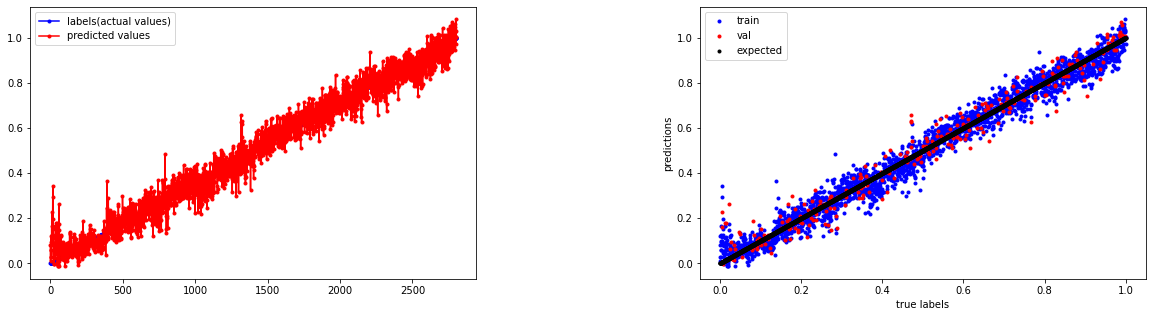

In [41]:
  train1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train/Bearing1_1_train.pkz']
  val1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation/Bearing1_1_validation.pkz']
  plot(train1_pfiles, val1_pfiles)

**Performance on bearing1_2.pkz dataset**

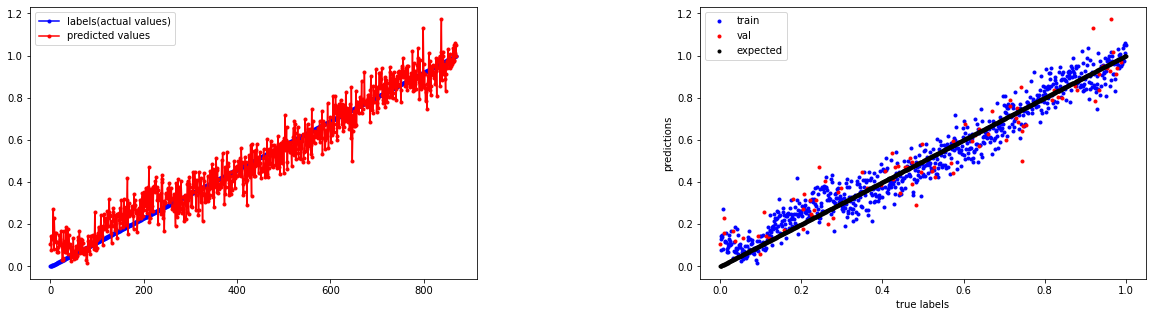

In [42]:
  train1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train/Bearing1_2_train.pkz']
  val1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation/Bearing1_2_validation.pkz']
  plot(train1_pfiles, val1_pfiles)

**Performance on bearing2_1.pkz dataset**

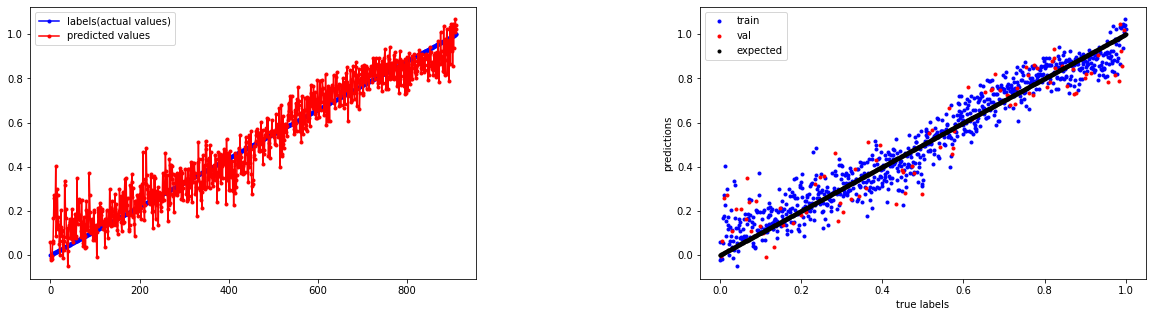

In [43]:
  train1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train/Bearing2_1_train.pkz']
  val1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation/Bearing2_1_validation.pkz']
  plot(train1_pfiles, val1_pfiles)

**Performance on bearing2_2.pkz dataset**

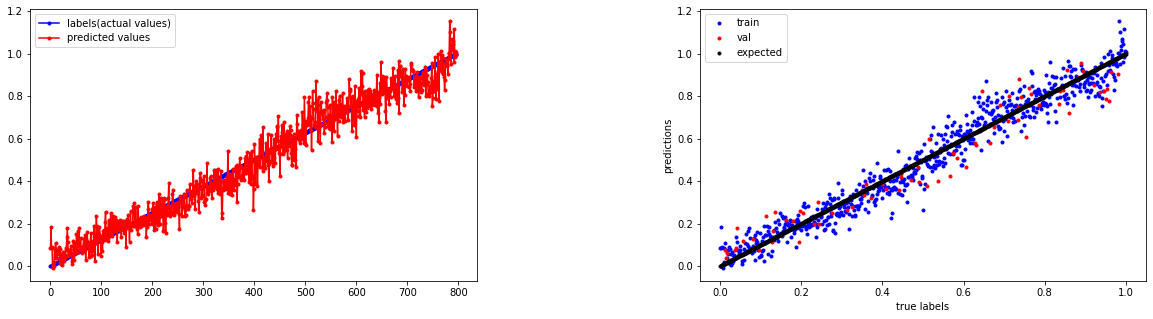

In [44]:
  train1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train/Bearing2_2_train.pkz']
  val1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation/Bearing2_2_validation.pkz']
  plot(train1_pfiles, val1_pfiles)

**Performance on bearing3_1.pkz dataset**

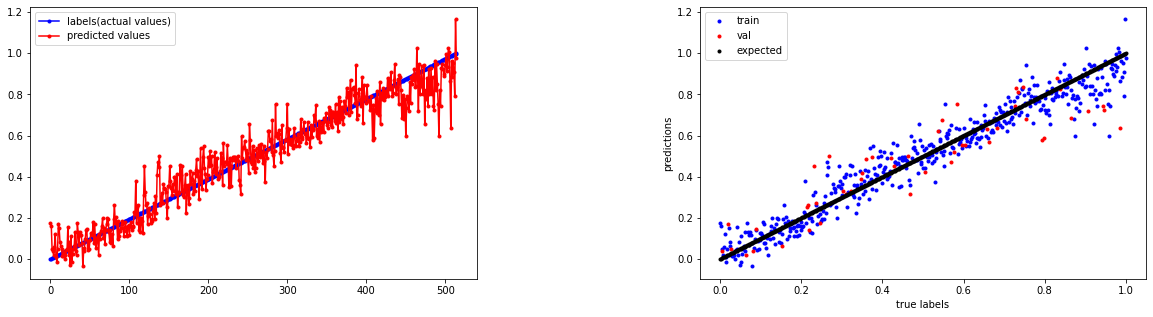

In [45]:
  train1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train/Bearing3_1_train.pkz']
  val1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation/Bearing3_1_validation.pkz']
  plot(train1_pfiles, val1_pfiles)

**Performance on bearing3_2.pkz dataset**

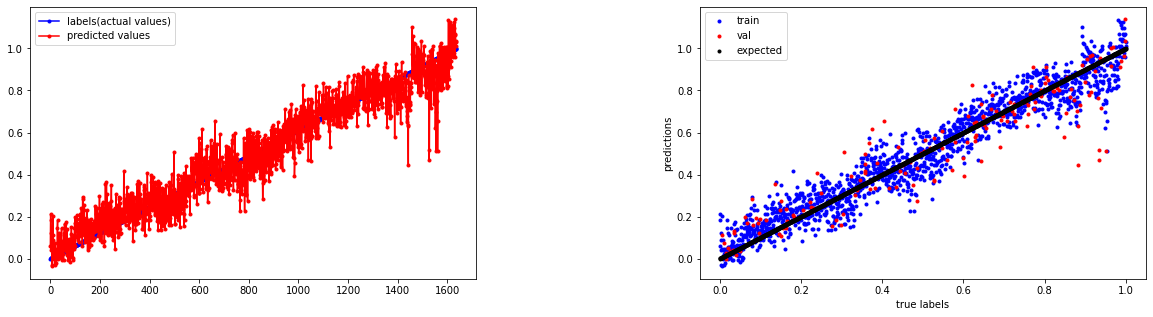

In [46]:
  train1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/train/Bearing3_2_train.pkz']
  val1_pfiles = ['/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/validation/Bearing3_2_validation.pkz']
  plot(train1_pfiles, val1_pfiles)